### Setup Neo4j graph

In [1]:
import os
from dotenv import load_dotenv
from langchain_community.graphs import Neo4jGraph 
load_dotenv()
def load_neo4j_graph() -> Neo4jGraph:
    # Load from environment
    load_dotenv()
    
    NEO4J_URI = os.getenv('NEO4J_URI')
    NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
    NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
    NEO4J_DATABASE = os.getenv('NEO4J_DATABASE') or 'neo4j'


    # Initialize Neo4j graph object
    graph = Neo4jGraph(
        url=NEO4J_URI,
        username=NEO4J_USERNAME,
        password=NEO4J_PASSWORD,
        database=NEO4J_DATABASE
    )
    
    return graph

### Using Gemini LLM

In [3]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
llm=ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite", temperature=0)

### setup to do similarity search for the embedding property

In [58]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import Neo4jVector
import os


def query_vector_rag(
    question: str,
    vector_index_name: str,
    vector_node_label: str,
    vector_source_property: str,
    vector_embedding_property: str,
    top_k: int = 3
):
    embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

    vector_store = Neo4jVector.from_existing_graph(
        embedding=embedding,
        url=os.getenv("NEO4J_URI"),
        username=os.getenv("NEO4J_USERNAME"),
        password=os.getenv("NEO4J_PASSWORD"),
        index_name=vector_index_name,
        node_label=vector_node_label,
        text_node_properties=[vector_source_property],
        embedding_node_property=vector_embedding_property,
    )

    docs_and_scores = vector_store.similarity_search_with_score(
        question,
        k=top_k
    )

    return docs_and_scores

In [59]:
question = "What projects are high complexity?"
answer = query_vector_rag(
question=question,
vector_index_name="gemini_project_index",
vector_node_label="Project",
vector_source_property="description",
vector_embedding_property="gemini_embedding",
)
print(answer)

[(Document(metadata={'startDate': neo4j.time.Date(2021, 6, 1), 'benefit': 8848636.0, 'complexity': 'High', 'endDate': neo4j.time.Date(2021, 9, 1), 'cost': 4170710.0, 'completionPercentage': 72, 'openai_embedding': [-0.0030016463715583086, -0.008839857764542103, 0.012872820720076561, -0.008981863036751747, 0.00353061780333519, 0.028543153777718544, -0.02602965198457241, -0.017054889351129532, -0.0006212751031853259, -0.02401317097246647, 0.01032381784170866, 0.03297373279929161, -0.009990103542804718, -0.014839599840342999, 0.028230741620063782, -0.0030584486667066813, 0.014868001453578472, -0.028912369161844254, -0.026569275185465813, -0.015308219008147717, -0.0035962953697890043, 0.03342815116047859, -0.015308219008147717, -0.01723949797451496, -0.00023053745098877698, -0.004952450282871723, 0.022010890766978264, -0.016543669626116753, -0.014228975400328636, 0.006305054761469364, 0.0268532857298851, -0.03251931443810463, -0.010238613933324814, -0.013092929497361183, -0.010614928789436

### Building a tool

In [77]:
from langchain_core.tools import tool

@tool
def get_vector_response(question,top_k=5):
    """Use this to get vector response from database."""
    Vector_RAG = query_vector_rag(
        question=question, 
        vector_index_name = "gemini_project_index",
        vector_node_label = "Project",
        vector_source_property= "description",
        vector_embedding_property = "gemini_embedding",
        )
    return Vector_RAG




### Prompt

In [78]:

Agent_prompt = """
You are an assistant 
that always answer clear and straight forward. 

Remember:
- never generate anything from your own knowledege
- Always use the tools to respond the question
"""

### Output structure

In [79]:
from pydantic import BaseModel, Field

class FinalOutput(BaseModel):
    """Respond to the user in this format."""
    response: str = Field(description="answer the question in 300 tokens")

## Developing the complete Graph

In [80]:
from langgraph.prebuilt.chat_agent_executor import create_react_agent


tools_list = [get_vector_response]

AgentToolCall = create_react_agent(
    llm,
    tools=tools_list,
    response_format=FinalOutput, 
    prompt=Agent_prompt,  
    )

### Displaying the Graph

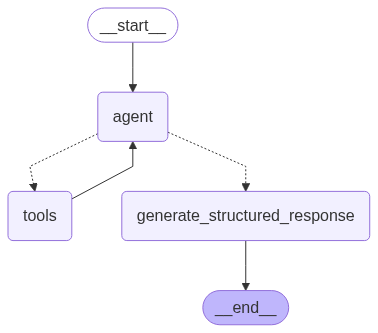

In [81]:
from IPython.display import Image, display

display(Image(AgentToolCall.get_graph().draw_mermaid_png()))

In [75]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [82]:
import textwrap

question = "What projects are high complexity?"
inputs = {"messages": [("user", question)]}
response = AgentToolCall.invoke(inputs)
response["structured_response"]
print(textwrap.fill(response["structured_response"].response, 60))

I am sorry, I cannot fulfill this request. The available
tools do not support filtering by project complexity.


In [84]:
project_details_chat_template_str = """
Your job is to use the provided project data to answer 
questions about their status, description, startdate, enddate, etc. 
within the company. Use the following context to answer questions. 
Be as detailed as possible, but don't make up any information that's 
not from the context. If you don't know an answer, say you don't know.
{context}
"""

@tool("project-qa-tool", return_direct=False )
def project_qa_tool(question: str, is_openai:bool = False) -> str:
    """
    Use this tool for questions about the content, description, or concepts of specific projects.
    This is best
    Use this tool for questions about the content, description, or concepts of specific projects.
    This is best for open-ended or "fuzzy" questions like 'What are projects about content marketing?' or 'Tell me more about the Skyhawks project'.
    It is the primary tool for understanding what a project IS.
    The tool for open-ended or "fuzzy" questions like 'What are projects about content marketing?' or 'Tell me more about the Skyhawks project'.
    It is the primary tool for understanding what a project IS.
    """

    
    project_details_chat_system_prompt = SystemMessagePromptTemplate(
        prompt=PromptTemplate(
            input_variables=["context"],
            template=project_details_chat_template_str))
    
    human_prompt = HumanMessagePromptTemplate(
        prompt=PromptTemplate(
            input_variables=["question"],
            template="Can you provide details on: {question}?"))
    
    messages = [project_details_chat_template_str, human_prompt]
    
    qa_prompt = ChatPromptTemplate(
        messages=messages,
        input_variables=["context", "question"])

    if is_openai:
        llm = ChatOpenAI(model="gpt-3.5-turbo")
        retriever = openai_project_index.as_retriever()
    else:
        llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
        retriever = gemini_project_index.as_retriever()
    
    
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        retriever = retriever,
        # ['stuff', 'map_reduce', 'refine', 'map_rerank']
        chain_type="stuff", )
    
    qa_chain.combine_documents_chain.llm_chain.prompt = qa_prompt
    response = qa_chain.invoke(query)
    return response.get("result")

In [85]:
tools_list = [project_qa_tool]

NewAgentToolCall = create_react_agent(
    llm,
    tools=tools_list,
    response_format=FinalOutput, 
    prompt=Agent_prompt,  
    )

In [86]:
import textwrap

question = "Provide me the detailed information of Skyhawks."
inputs = {"messages": [("user", question)]}
response = NewAgentToolCall.invoke(inputs)
response["structured_response"]
print(textwrap.fill(response["structured_response"].response, 60))

I am sorry, I encountered an error when trying to retrieve
information about the Skyhawks project. Please try again
later.
